In [281]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from scipy.interpolate import CubicSpline

In [340]:
df = load_wisdm_dataset("E:/dataset/HAR/WISDM/WISDM_ar_v1.1_raw.txt")
print(df.head())
print(df['activity'].value_counts())

   user activity       timestamp         x          y         z
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164
activity
Walking       418395
Jogging       336450
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64


In [341]:
zero_xyz_rows = df[(df['x'] == 0) & (df['y'] == 0) & (df['z'] == 0)]

# activity(또는 label)별 개수 출력
print(zero_xyz_rows['activity'].value_counts())

activity
Jogging       11845
Walking         491
Upstairs        271
Downstairs      233
Standing          1
Name: count, dtype: int64


In [342]:
df_cleaned = df[~((df['x'] == 0) & (df['y'] == 0) & (df['z'] == 0))]

In [343]:
print(df_cleaned['activity'].value_counts())

activity
Walking       417904
Jogging       324605
Upstairs      122598
Downstairs    100194
Sitting        59939
Standing       48394
Name: count, dtype: int64


In [344]:
import torch
import torch.nn as nn
import math
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=128):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.downsample = (
            nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            ) if in_channels != out_channels or stride != 1 else nn.Identity()
        )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)


def make_resnet_blocks(in_channels, out_channels, num_blocks):
    layers = []
    for i in range(num_blocks):
        layers.append(ResidualBlock(
            in_channels if i == 0 else out_channels,
            out_channels
        ))
    return nn.Sequential(*layers)


class ResNetTransformer(nn.Module):
    def __init__(self,
                 num_classes,
                 input_channels=9,
                 seq_len=128,
                 d_model=64,
                 nhead=4,
                 num_resnet_blocks=2,
                 num_transformer_layers=1,
                 num_rt_repeats=2):
        super().__init__()
        self.seq_len = seq_len
        self.num_rt_repeats = num_rt_repeats
        self.rt_blocks = nn.ModuleList()
        in_ch = input_channels

        for _ in range(num_rt_repeats):
            resnet = make_resnet_blocks(in_ch, d_model, num_resnet_blocks)
            proj = nn.Linear(d_model, d_model)
            pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
            encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model * 2, dropout=0.1)
            transformer = TransformerEncoder(encoder_layer, num_transformer_layers)
            self.rt_blocks.append(nn.ModuleDict({
                'resnet': resnet,
                'proj': proj,
                'pos_encoder': pos_encoder,
                'transformer': transformer
            }))
            in_ch = d_model

        self.fc = nn.Linear(seq_len * d_model, num_classes)

    def forward(self, x):
        # 처음 입력이 (B, T, C)일 경우 Conv1d를 위해 (B, C, T)로 변경
        if x.shape[1] == self.seq_len:
            x = x.permute(0, 2, 1)  # (B, C, T)

        for block in self.rt_blocks:
            x = block['resnet'](x)          # (B, C, T)
            x = x.permute(0, 2, 1)          # (B, T, C)
            x = block['proj'](x)            # (B, T, d_model)
            x = x.permute(1, 0, 2)          # (T, B, d_model)
            x = block['pos_encoder'](x)
            x = block['transformer'](x)
            x = x.permute(1, 0, 2)          # (B, T, d_model)
            x = x.permute(0, 2, 1)          # (B, d_model, T) for next ResNet

        x = x.permute(0, 2, 1)              # (B, T, d_model)
        x = x.reshape(x.size(0), -1)        # (B, T * d_model)
        return self.fc(x)                   # (B, num_classes)



In [345]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

class SensorDataset(Dataset):
    def __init__(self, df, label_encoder, window_size=128, stride=64):
        self.segments = []
        self.labels = []
        df = df.sort_values('timestamp')
        grouped = df.groupby('user')

        for _, user_df in grouped:
            user_df = user_df.sort_values('timestamp')
            activity_groups = user_df.groupby('activity')
            for activity, act_df in activity_groups:
                signal = act_df[['x', 'y', 'z']].values
                for i in range(0, len(signal) - window_size + 1, stride):
                    window = signal[i:i+window_size].T  # (3, 128)
                    self.segments.append(window)
                    self.labels.append(label_encoder.transform([activity])[0])

        self.segments = torch.tensor(np.array(self.segments), dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx], self.labels[idx] 


def prepare_train_val_test_dataloaders(combined_df, test_df, batch_size=64, window_size=128, stride=64, val_ratio=0.2):
    # 라벨 인코더 준비
    label_encoder = LabelEncoder()
    label_encoder.fit(combined_df['activity'].unique())

    # combined_df → 훈련/검증 split (user 기준 아님, window 기준)
    train_df, val_df = train_test_split(combined_df, test_size=val_ratio, stratify=combined_df['activity'], random_state=42)

    # Dataset 구성
    train_dataset = SensorDataset(train_df, label_encoder, window_size=window_size, stride=stride)
    val_dataset = SensorDataset(val_df, label_encoder, window_size=window_size, stride=stride)
    test_dataset = SensorDataset(test_df, label_encoder, window_size=window_size, stride=stride)

    # DataLoader 구성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, label_encoder


# ----------------------------
# 정확도 계산 함수
# ----------------------------
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).float().mean().item()

# ----------------------------
# 훈련 함수
# ----------------------------
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x_batch.size(0)
            train_acc += accuracy(outputs, y_batch) * x_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)

        # --------------------------
        # Validation
        # --------------------------
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for x_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * x_batch.size(0)
                val_acc += accuracy(outputs, y_batch) * x_batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc /= len(val_loader.dataset)

        print(f"🌟 Epoch {epoch+1} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


# ----------------------------
# 실행
# ----------------------------
if __name__ == '__main__':

    # DataLoader 구성
    train_loader, val_loader, test_loader, label_encoder = prepare_train_val_test_dataloaders(
    df_cleaned, test_df, batch_size=64, window_size=128, stride=64, val_ratio=0.2)
    
    # 모델 초기화
    model = ResNetTransformer(
        num_classes=len(label_encoder.classes_),
        input_channels=3,
        seq_len=128,
        d_model=64,
        nhead=4,
        num_resnet_blocks=1,
        num_transformer_layers=1,
        num_rt_repeats=2
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 모델 학습
    train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=1)


C:\ProgramData\anaconda33\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1/1 [Val]: 100%|█████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 35.24it/s]

🌟 Epoch 1 - Train Loss: 0.7085, Train Acc: 0.7880 | Val Loss: 0.9565, Val Acc: 0.6922



📊 Classification Report:
              precision    recall  f1-score   support

  Downstairs     0.2019    0.8189    0.3239       265
     Jogging     0.8571    0.9917    0.9195       968
     Sitting     0.9733    0.9481    0.9605       154
    Standing     0.9583    0.9746    0.9664       118
    Upstairs     0.4302    0.5522    0.4837       335
     Walking     0.9697    0.1532    0.2646      1253

    accuracy                         0.5868      3093
   macro avg     0.7318    0.7398    0.6531      3093
weighted avg     0.8100    0.5868    0.5598      3093



C:\ProgramData\anaconda33\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


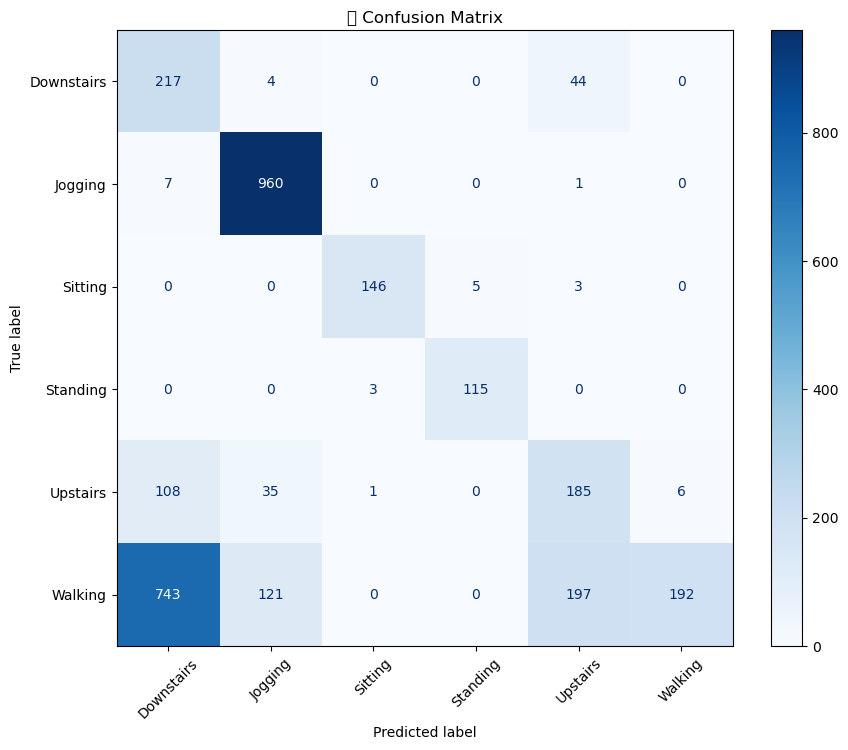

In [337]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, dataloader, label_encoder, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = y_batch.numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    # 인코딩된 라벨을 다시 클래스 이름으로 변환
    target_names = label_encoder.classes_
    
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title("🧩 Confusion Matrix")
    plt.show()

if __name__ == '__main__':

    evaluate_model(model, val_loader, label_encoder, device)

In [16]:
csv_path = "E:/dataset/HAR/WISDM/WISDM.csv"  

df = pd.read_csv(csv_path, index_col=0)
df.columns = ['user', 'activity', 'timestamp', 'x', 'y', 'z']

# 데이터 확인
print(df.head())
print("\n[📊 Activity 분포]")
print(df['activity'].value_counts())

   user activity     timestamp         x          y         z
0                                                            
1    33  Jogging  4.910610e+13  5.012288  11.264028  0.953424
2    33  Jogging  4.910610e+13  4.903325  10.882658 -0.081722
3    33  Jogging  4.910620e+13 -0.612916  18.496431  3.023717
4    33  Jogging  4.910630e+13 -1.184970  12.108489  7.205164
5    33  Jogging  4.910640e+13  1.375655  -2.492524 -6.510526

[📊 Activity 분포]
activity
Walking       406775
Jogging       325974
Upstairs      118589
Downstairs     97813
Sitting        54876
Standing       44547
Name: count, dtype: int64


In [17]:
zero_xyz_rows = df[(df['x'] == 0) & (df['y'] == 0) & (df['z'] == 0)]

# activity(또는 label)별 개수 출력
print(zero_xyz_rows['activity'].value_counts())

activity
Jogging       11843
Walking         491
Upstairs        271
Downstairs      232
Standing          1
Name: count, dtype: int64


In [18]:
df_cleaned = df[~((df['x'] == 0) & (df['y'] == 0) & (df['z'] == 0))]

In [19]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# 1. Sliding window (좋은 세그먼트 선별용)
def create_windows(df, window_size=128, stride=64):
    windows, labels = [], []
    for user in df['user'].unique():
        user_df = df[df['user'] == user]
        for activity in user_df['activity'].unique():
            act_df = user_df[user_df['activity'] == activity].sort_values('timestamp')
            sig = act_df[['x', 'y', 'z']].values
            for i in range(0, len(sig) - window_size + 1, stride):
                windows.append(sig[i:i+window_size])
                labels.append(activity)
    return np.array(windows), np.array(labels)

# 2. Rich feature 추출
def extract_rich_features(segment, fs=20):
    features = []
    for axis in range(segment.shape[1]):
        sig = segment[:, axis]
        std = np.std(sig)
        energy = np.sum(sig**2)
        peaks, _ = find_peaks(sig, distance=fs//2, prominence=0.2)
        n_peaks = len(peaks)
        features += [std, energy, n_peaks]
    return np.array(features)

# 3. 좋은 세그먼트 선택
def select_good_segments(windows, features, labels, threshold=0.5, peak_weight=5):
    stds = features[:, [0, 3, 6]].sum(axis=1)
    energy = features[:, [1, 4, 7]].sum(axis=1)
    peaks = features[:, [2, 5, 8]].sum(axis=1)
    score = stds + energy + peaks * peak_weight

    good_idx = np.where(score > np.percentile(score, 100 * threshold))[0]

    # 💡 클래스별 good segment를 가능한 모두 선택
    selected = []
    selected_labels = []
    for label in np.unique(labels[good_idx]):
        class_idx = good_idx[labels[good_idx] == label]
        if len(class_idx) < 2:
            continue  # CutMix는 최소 2개 필요
        for idx in class_idx:
            selected.append(windows[idx])
            selected_labels.append(label)

    return np.array(selected), np.array(selected_labels)



# 4. CutMix
def cutmix_segments(seg1, seg2, alpha=0.5):
    lam = np.random.beta(alpha, alpha)
    cut_size = int(lam * seg1.shape[0])
    start = np.random.randint(0, seg1.shape[0] - cut_size + 1)
    mixed = seg1.copy()
    mixed[start:start+cut_size] = seg2[start:start+cut_size]
    return mixed, lam

# 5. 클래스별 CutMix
def apply_cutmix_per_class_fast(windows, labels, max_pairs=100):
    unique_labels = np.unique(labels)
    mixed_segments, mixed_labels = [], []

    for label in unique_labels:
        idx = np.where(labels == label)[0]
        class_windows = windows[idx]
        if len(idx) < 2:
            continue
        for _ in range(min(max_pairs, len(idx) * (len(idx) - 1) // 2)):
            i, j = np.random.choice(len(idx), 2, replace=False)
            mixed_seg, _ = cutmix_segments(class_windows[i], class_windows[j])
            mixed_segments.append(mixed_seg)
            mixed_labels.append(label)

    return np.array(mixed_segments), np.array(mixed_labels)

# ✅ 전체 파이프라인
def pipeline_cutmix_good_segments_per_class(df, window_size=128, stride=64, threshold=0.1):
    windows, labels = create_windows(df, window_size, stride)
    print("슬라이딩 윈도우 완료")

    features = np.array([extract_rich_features(w) for w in windows])
    print("Rich feature 추출 완료")

    good_segments, good_labels = select_good_segments(windows, features, labels, threshold=threshold)
    print("좋은 세그먼트 추출 완료")

    mixed_segments, mixed_labels = apply_cutmix_per_class_fast(good_segments, good_labels)
    print("CutMix 완료")

    return mixed_segments, mixed_labels

# ✅ 실행 및 저장
if __name__ == "__main__":
    mixed_segs, mixed_labels = pipeline_cutmix_good_segments_per_class(df_cleaned, threshold=0.1)

    print("Mixed segments shape:", mixed_segs.shape)
    print("Labels shape:", mixed_labels.shape)
    print("Unique labels:", np.unique(mixed_labels))


슬라이딩 윈도우 완료
Rich feature 추출 완료
좋은 세그먼트 추출 완료
CutMix 완료
Mixed segments shape: (500, 128, 3)
Labels shape: (500,)
Unique labels: ['Downstairs' 'Jogging' 'Sitting' 'Upstairs' 'Walking']


In [26]:
import pandas as pd
import numpy as np

# mixed_segs: (400, 128, 3)
# mixed_labels: (400,)

all_records = []

for seg, label in zip(mixed_segs, mixed_labels):
    for t in range(seg.shape[0]):  # 128 time steps
        x, y, z = seg[t]
        all_records.append({
            "x": x,
            "y": y,
            "z": z,
            "label": label
        })

# DataFrame 생성
df_time_aligned = pd.DataFrame(all_records)

# 확인
print(df_time_aligned.shape)     # (51200, 4)
print(df_time_aligned.head())

# 저장
df_time_aligned.to_csv("cutmix_segments_long_format.csv", index=False)
print("✅ 저장 완료: cutmix_segments_long_format.csv")


(64000, 4)
      x      y     z       label
0 -2.37   8.69 -6.43  Downstairs
1 -1.69  11.84 -6.13  Downstairs
2  0.08  14.79 -2.72  Downstairs
3 -1.88   8.31 -2.22  Downstairs
4 -5.86   7.40  2.26  Downstairs
✅ 저장 완료: cutmix_segments_long_format.csv


In [21]:
df_time_aligned['label'].value_counts()

label
Downstairs    12800
Jogging       12800
Sitting       12800
Upstairs      12800
Walking       12800
Name: count, dtype: int64

In [33]:
df_time_aligned = df_time_aligned.rename(columns={"label": "activity"})


🔍 비교 시각화: 클래스 = Downstairs


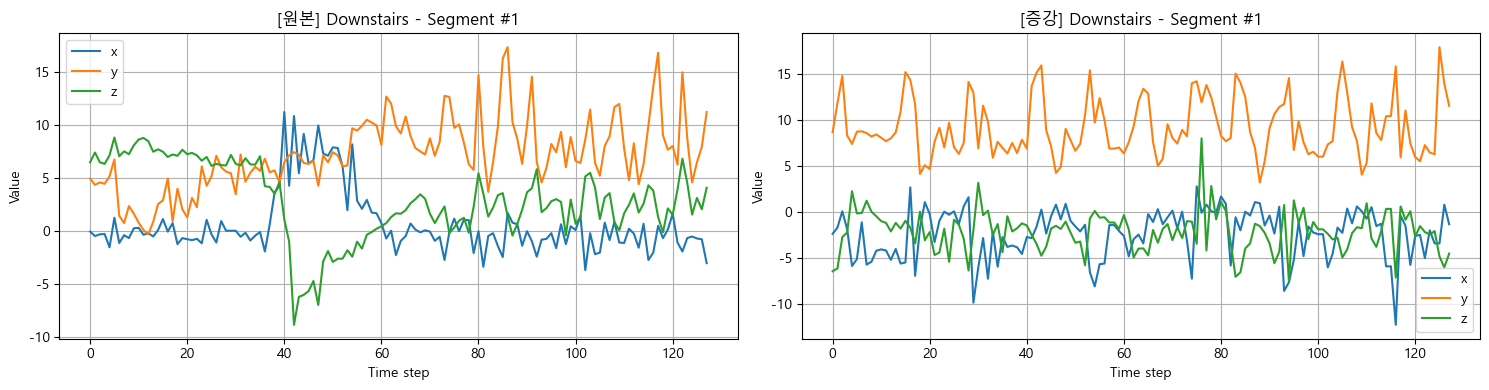


🔍 비교 시각화: 클래스 = Jogging


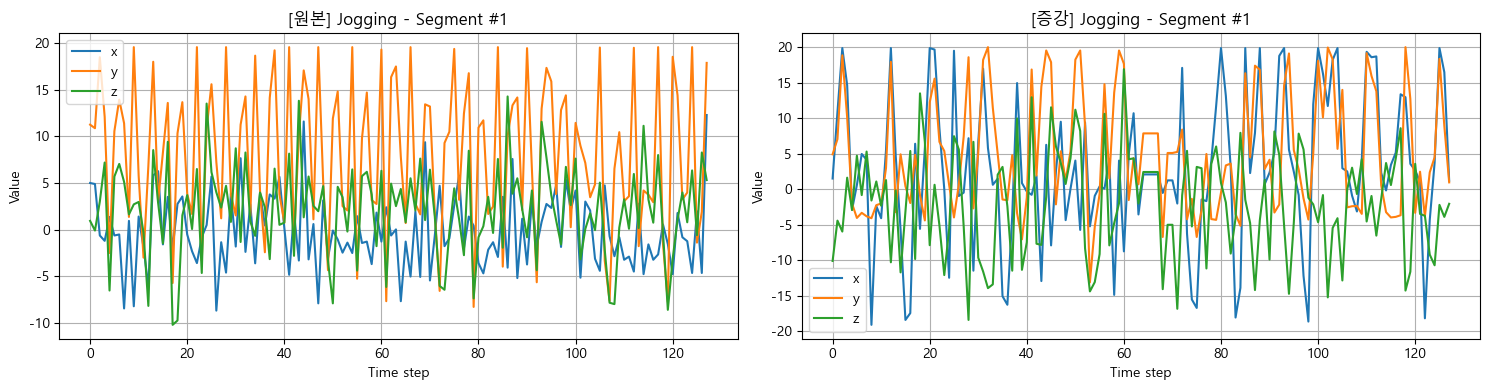


🔍 비교 시각화: 클래스 = Sitting


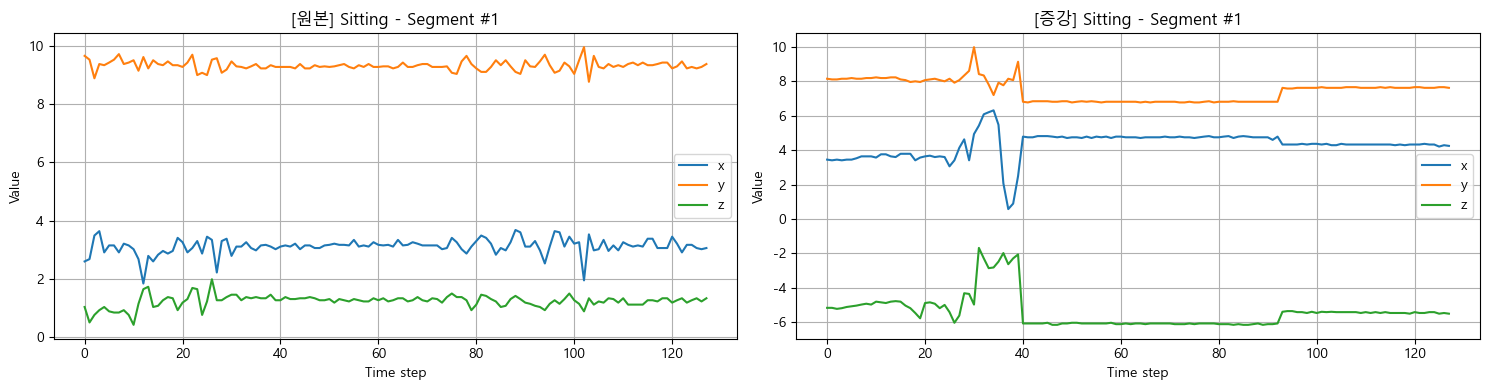


🔍 비교 시각화: 클래스 = Upstairs


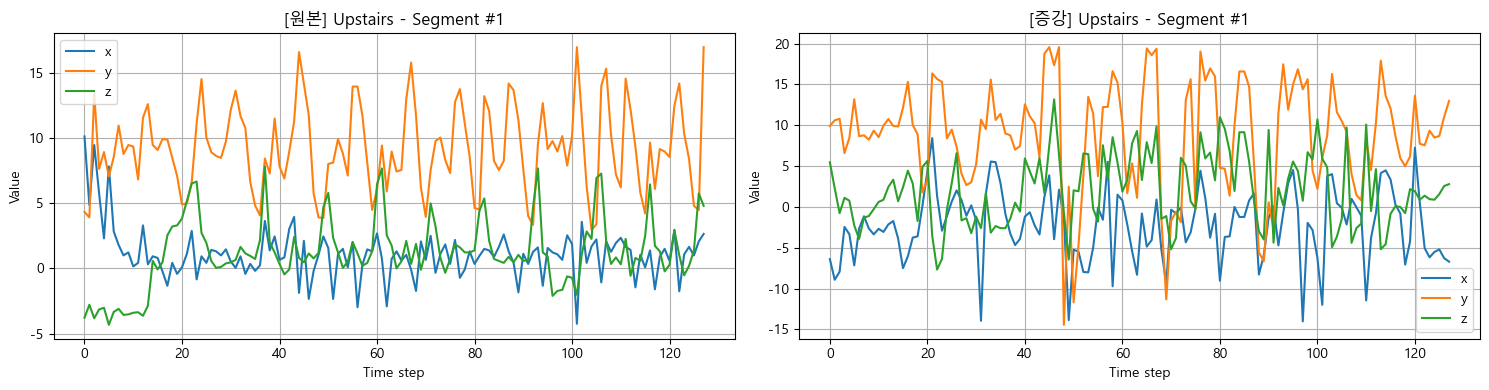


🔍 비교 시각화: 클래스 = Walking


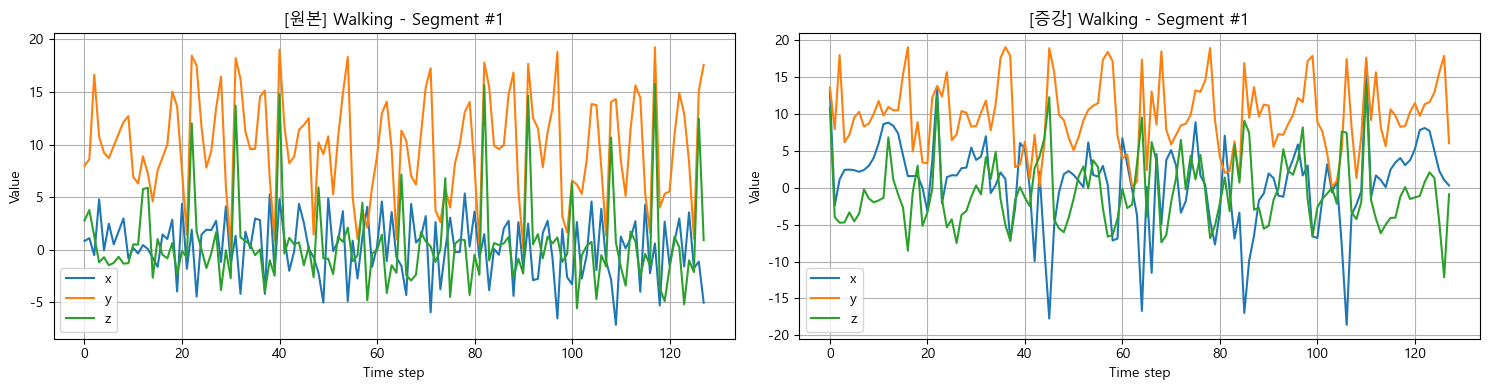

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Windows 기준 맑은 고딕 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
def compare_segments_between_datasets(df1, df2, label_col='label', samples_per_class=1):
    labels1 = df1[label_col].unique()
    labels2 = df2[label_col].unique()
    common_labels = sorted(set(labels1) & set(labels2))

    for label in common_labels:
        subset1 = df1[df1[label_col] == label].reset_index(drop=True)
        subset2 = df2[df2[label_col] == label].reset_index(drop=True)

        print(f"\n🔍 비교 시각화: 클래스 = {label}")

        for i in range(samples_per_class):
            start = i * 128
            end = start + 128

            seg1 = subset1.iloc[start:end]
            seg2 = subset2.iloc[start:end]

            plt.figure(figsize=(15, 4))

            # 원본 or 전처리 데이터
            plt.subplot(1, 2, 1)
            plt.plot(seg1["x"].values, label="x")
            plt.plot(seg1["y"].values, label="y")
            plt.plot(seg1["z"].values, label="z")
            plt.title(f"[원본] {label} - Segment #{i+1}")
            plt.xlabel("Time step")
            plt.ylabel("Value")
            plt.legend()
            plt.grid(True)

            # 증강 데이터
            plt.subplot(1, 2, 2)
            plt.plot(seg2["x"].values, label="x")
            plt.plot(seg2["y"].values, label="y")
            plt.plot(seg2["z"].values, label="z")
            plt.title(f"[증강] {label} - Segment #{i+1}")
            plt.xlabel("Time step")
            plt.ylabel("Value")
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

# 예시 실행
compare_segments_between_datasets(df_cleaned, df_time_aligned, label_col='activity', samples_per_class=1)


In [37]:
plt.savefig("E:/dataset/HAR/WISDM/fig.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

🔍 Jogging 클래스 시각화 중...


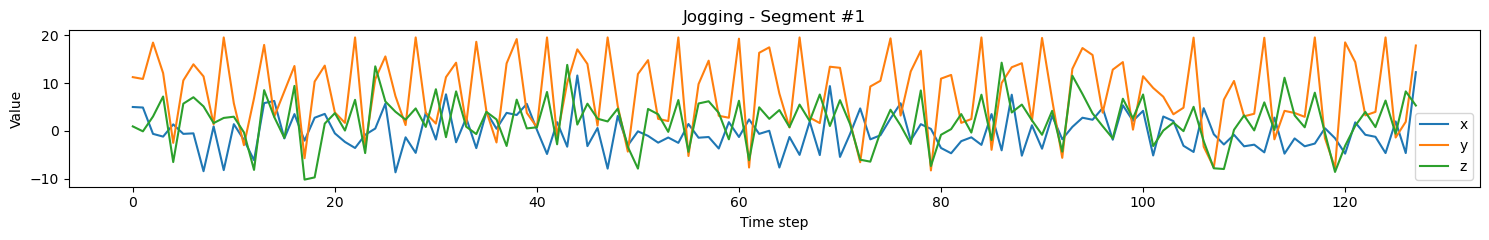

🔍 Walking 클래스 시각화 중...


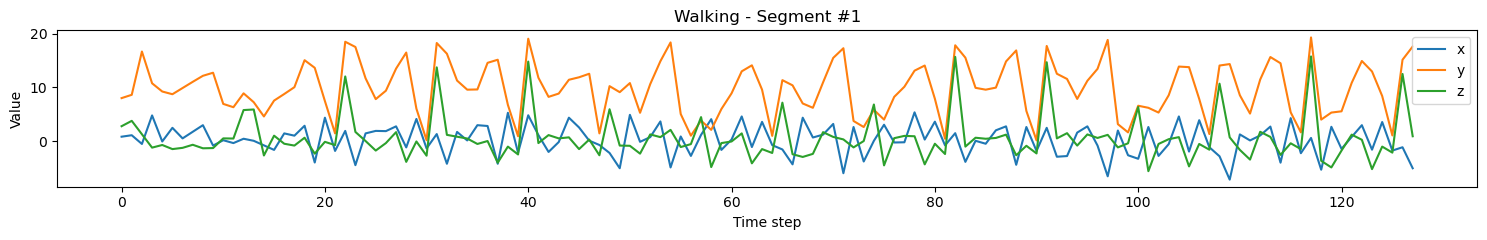

🔍 Upstairs 클래스 시각화 중...


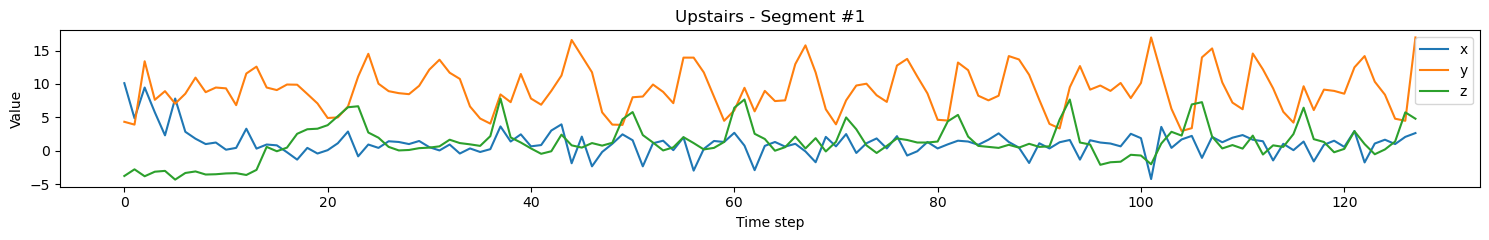

🔍 Downstairs 클래스 시각화 중...


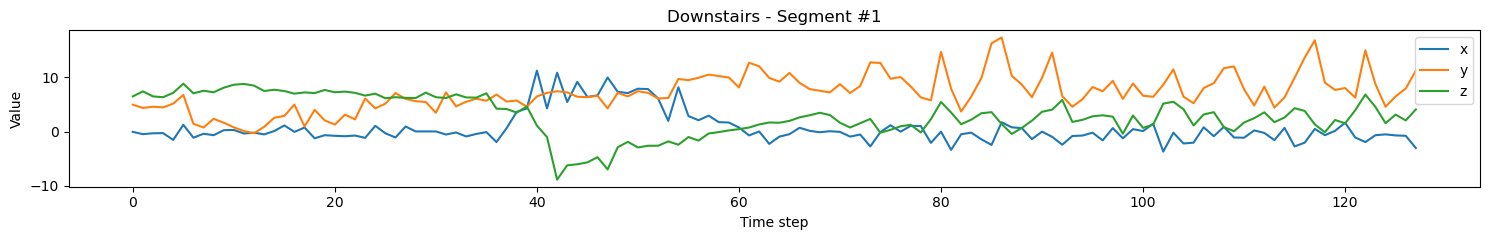

🔍 Sitting 클래스 시각화 중...


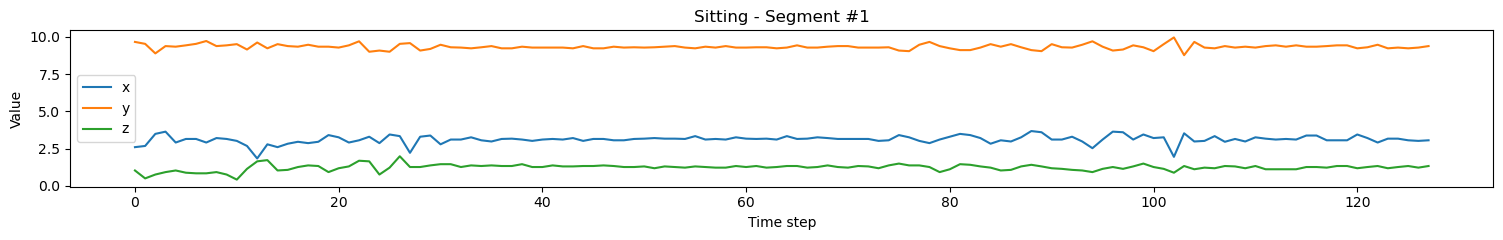

🔍 Standing 클래스 시각화 중...


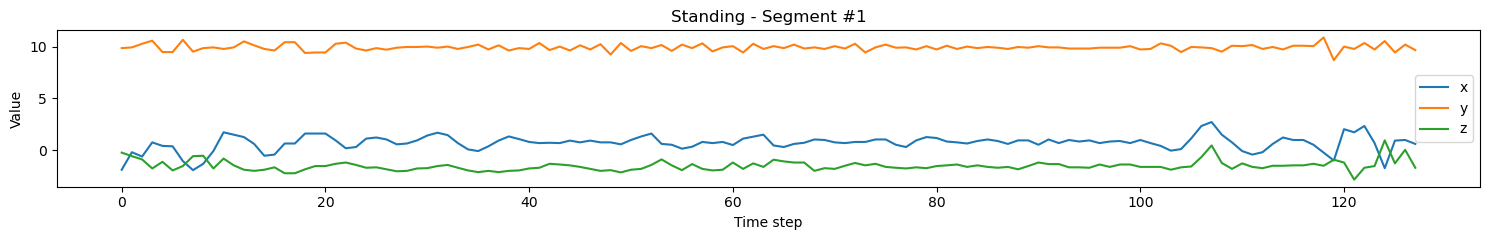

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_segments_per_class(df, samples_per_class=5):
    unique_labels = df["activity"].unique()
    for label in unique_labels:
        subset = df[df["activity"] == label].reset_index(drop=True)

        # 각 segment는 128개 row 단위로 나뉨
        print(f"🔍 {label} 클래스 시각화 중...")

        plt.figure(figsize=(15, samples_per_class * 2.5))
        for i in range(samples_per_class):
            start = i * 128
            end = start + 128
            segment = subset.iloc[start:end]

            plt.subplot(samples_per_class, 1, i + 1)
            plt.plot(segment["x"].values, label="x")
            plt.plot(segment["y"].values, label="y")
            plt.plot(segment["z"].values, label="z")
            plt.title(f"{label} - Segment #{i+1}")
            plt.xlabel("Time step")
            plt.ylabel("Value")
            plt.legend()
            plt.tight_layout()
        plt.show()

# 예시 사용
visualize_segments_per_class(df_cleaned, samples_per_class=1)


In [23]:
df_cleaned.columns

Index(['user', 'activity', 'timestamp', 'x', 'y', 'z'], dtype='object')

In [27]:
print(df_time_aligned.shape)             # (400, 385)
print(df_time_aligned["label"].value_counts())  # 레이블 분포

(64000, 4)
label
Downstairs    12800
Jogging       12800
Sitting       12800
Upstairs      12800
Walking       12800
Name: count, dtype: int64


🔍 Downstairs 클래스 시각화 중...


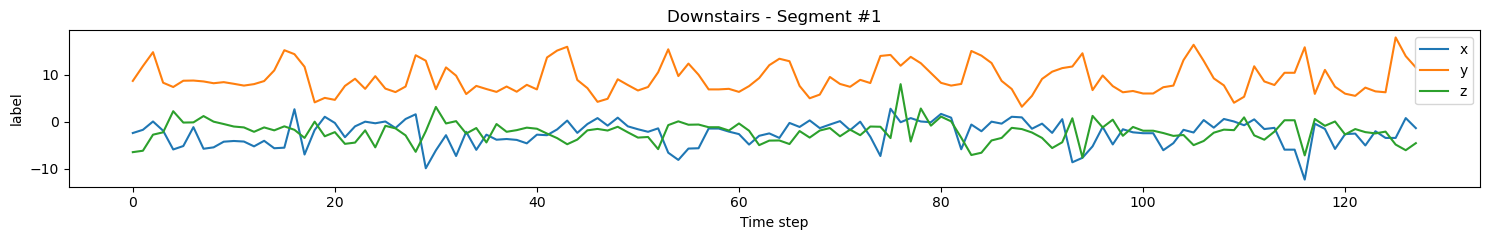

🔍 Jogging 클래스 시각화 중...


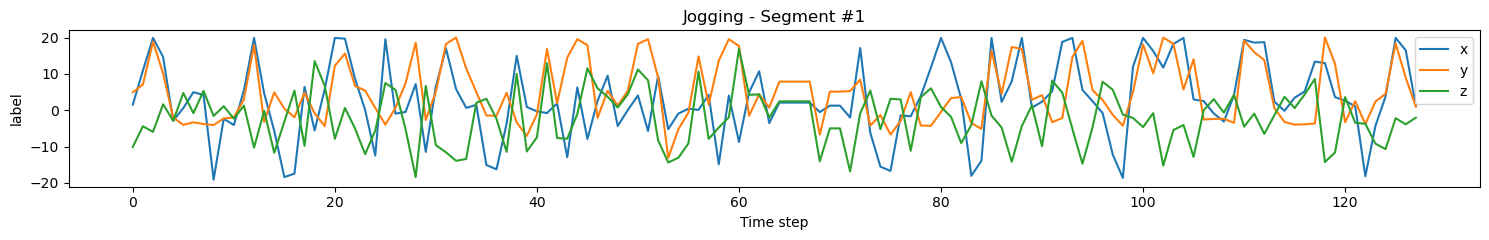

🔍 Sitting 클래스 시각화 중...


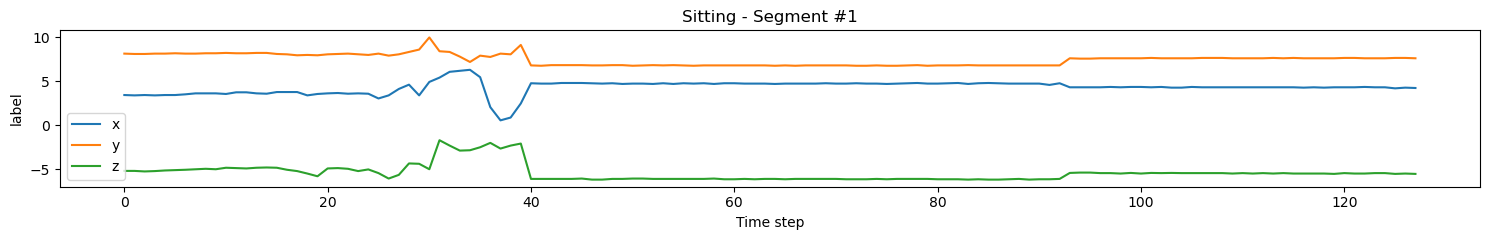

🔍 Upstairs 클래스 시각화 중...


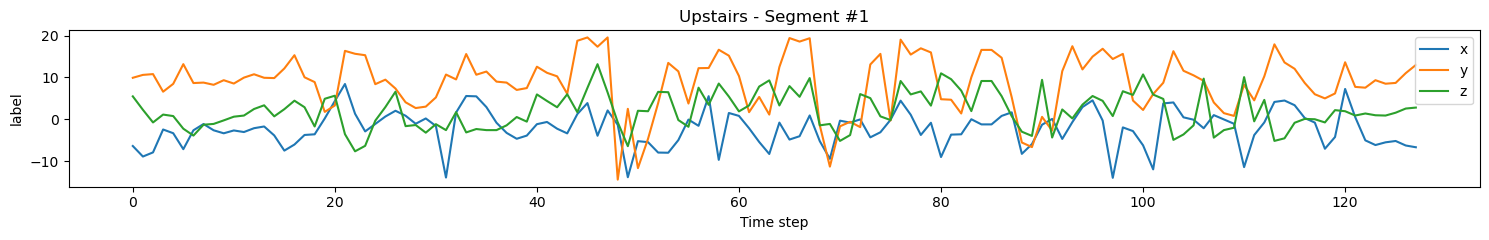

🔍 Walking 클래스 시각화 중...


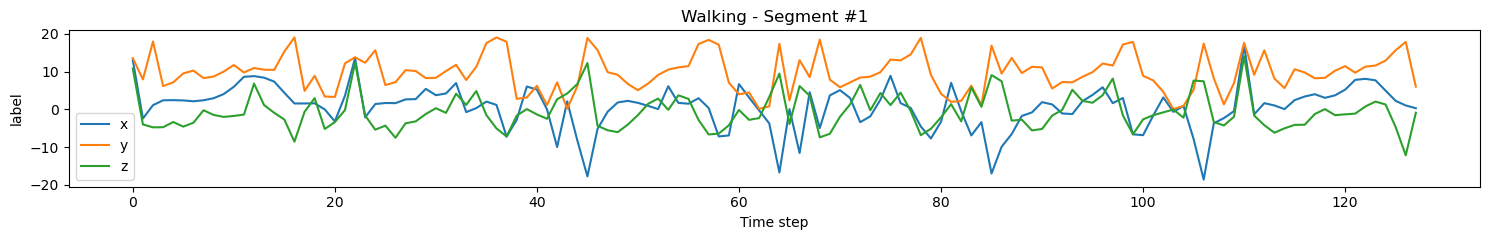

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_segments_per_class(df, samples_per_class=5):
    unique_labels = df["label"].unique()
    for label in unique_labels:
        subset = df[df["label"] == label].reset_index(drop=True)

        # 각 segment는 128개 row 단위로 나뉨
        print(f"🔍 {label} 클래스 시각화 중...")

        plt.figure(figsize=(15, samples_per_class * 2.5))
        for i in range(samples_per_class):
            start = i * 128
            end = start + 128
            segment = subset.iloc[start:end]

            plt.subplot(samples_per_class, 1, i + 1)
            plt.plot(segment["x"].values, label="x")
            plt.plot(segment["y"].values, label="y")
            plt.plot(segment["z"].values, label="z")
            plt.title(f"{label} - Segment #{i+1}")
            plt.xlabel("Time step")
            plt.ylabel("label")
            plt.legend()
            plt.tight_layout()
        plt.show()

# 예시 사용
visualize_segments_per_class(df_time_aligned, samples_per_class=1)


Total windows: 16126
Feature shape: (16126, 24)
Generated 9 mixed segments


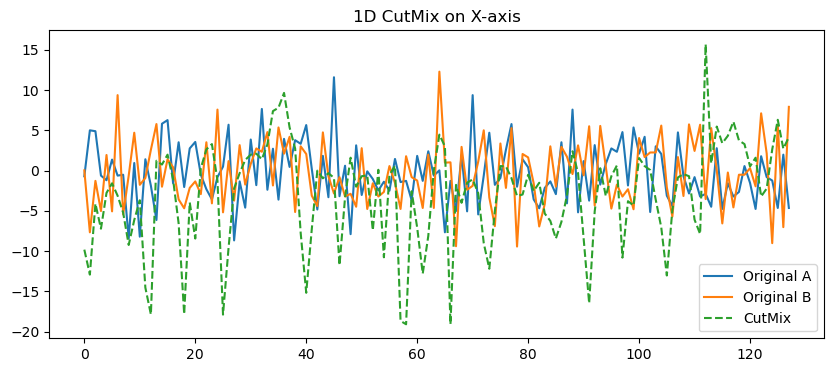

In [27]:
# 예시 시각화
plt.figure(figsize=(10, 4))
plt.plot(windows[0][:, 0], label="Original A")
plt.plot(windows[1][:, 0], label="Original B")
plt.plot(mixed[0][:, 0], label="CutMix", linestyle='--')
plt.legend()
plt.title("1D CutMix on X-axis")
plt.show()

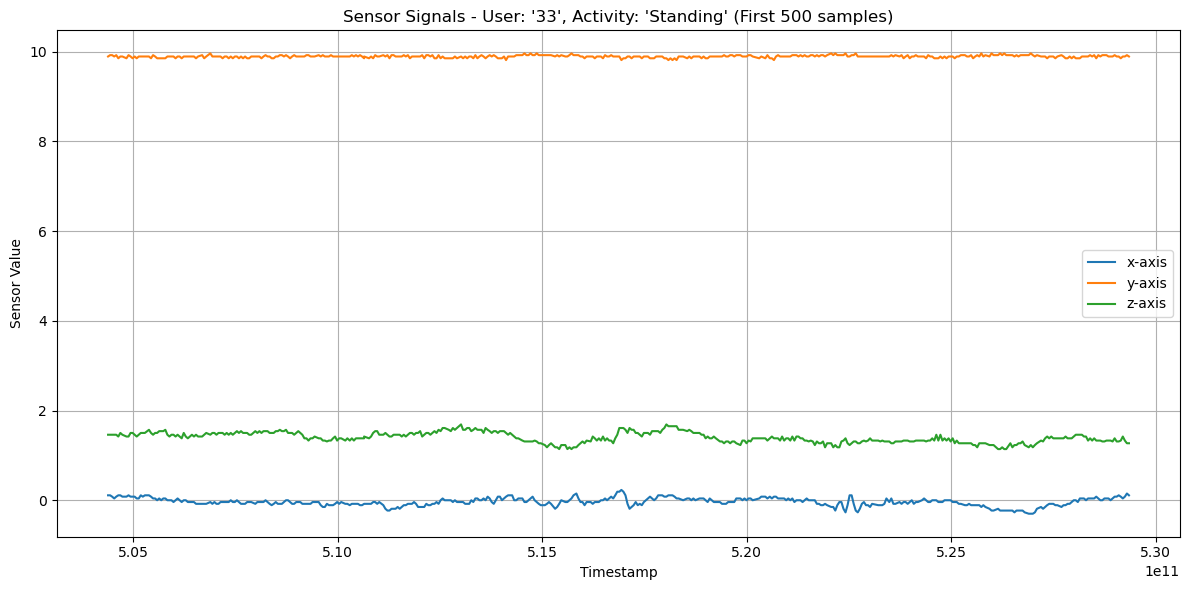

In [268]:
import pandas as pd
import matplotlib.pyplot as plt

# 사용자 ID 지정 (예: 사용자 ID가 'user01'인 경우)
target_user = 33
# 1. 'Standing' 활동이면서 해당 사용자의 데이터만 필터링
standing_df = df[(df['activity'] == 'Standing') & (df['user'] == target_user)]

# 2. timestamp 기준 정렬
standing_df = standing_df.sort_values('timestamp')

# 3. 처음 500개 선택
sample_df = standing_df.head(500)

# 4. 시각화
plt.figure(figsize=(12, 6))
plt.plot(sample_df['timestamp'], sample_df['x'], label='x-axis')
plt.plot(sample_df['timestamp'], sample_df['y'], label='y-axis')
plt.plot(sample_df['timestamp'], sample_df['z'], label='z-axis')

plt.title(f"Sensor Signals - User: '{target_user}', Activity: 'Standing' (First 500 samples)")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




📊 Classification Report:
              precision    recall  f1-score   support

  Downstairs     0.6437    0.6706    0.6569       765
     Jogging     0.7679    0.9948    0.8667       765
     Sitting     1.0000    0.9833    0.9916       777
    Standing     0.9897    0.9948    0.9923       774
    Upstairs     0.7616    0.7516    0.7566       765
     Walking     0.7874    0.5968    0.6790       987

    accuracy                         0.8218      4833
   macro avg     0.8251    0.8320    0.8238      4833
weighted avg     0.8241    0.8218    0.8179      4833



C:\ProgramData\anaconda33\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


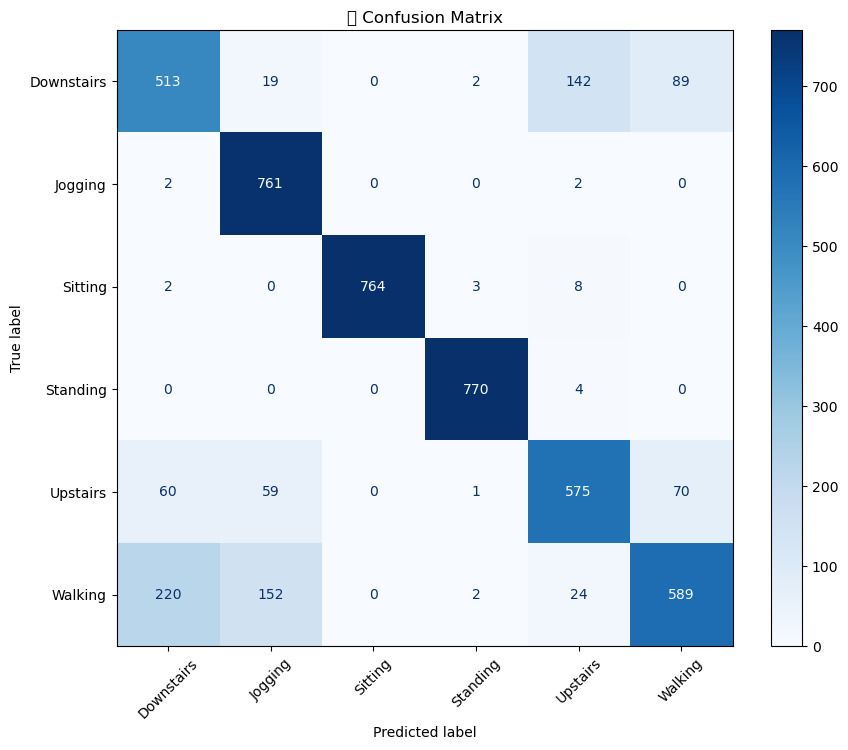

In [271]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, dataloader, label_encoder, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = y_batch.numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    # 인코딩된 라벨을 다시 클래스 이름으로 변환
    target_names = label_encoder.classes_
    
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title("🧩 Confusion Matrix")
    plt.show()

if __name__ == '__main__':

    evaluate_model(model, val_loader, label_encoder, device)
